This notebook is part of the *orix* documentation https://orix.rtfd.io. Links to the documentation won’t work from the notebook.

# Clustering orientations

This notebook illustrates clustering of Ti crystal orientations using data
obtained from a highly deformed specimen, using EBSD, as presented in
<cite data-cite="johnstone2020density">Johnstone et al. (2020)</cite>.  The data
can be downloaded to your local cache via the
[orix.data](reference.rst#data) module.

Import orix classes and various dependencies

In [1]:
# exchange inline for notebook (or qt5 from pyqt) for interactive plotting
%matplotlib inline

# Import core external
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Colorisation and visualisation
from matplotlib.colors import to_rgb
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D
from skimage.color import label2rgb

# Import orix classes 
from orix import data, plot
from orix.quaternion import Orientation, OrientationRegion, Rotation
from orix.quaternion.symmetry import D6
from orix.vector import AxAngle, Vector3d


plt.rcParams.update({
    "font.size": 20, "figure.figsize": (10, 10), "figure.facecolor": "w"
})

## Import data

Load Ti orientations with the point group symmetry *D6* (*622*). We have to
explicitly allow download from an external source.

In [2]:
ori = data.ti_orientations(allow_download=True)
ori

Orientation (193167,) 622
[[ 0.3027  0.0869 -0.5083  0.8015]
 [ 0.3088  0.0868 -0.5016  0.8034]
 [ 0.3057  0.0818 -0.4995  0.8065]
 ...
 [ 0.4925 -0.1633 -0.668   0.5334]
 [ 0.4946 -0.1592 -0.6696  0.5307]
 [ 0.4946 -0.1592 -0.6696  0.5307]]

The orientations define transformations from the sample (lab) to the crystal
reference frame, i.e. the Bunge convention. The above referenced paper assumes
the opposite convention, which is the one used in MTEX. So, we have to invert
the orientations

In [3]:
ori = ~ori

Reshape the orientation mapping data to the correct spatial dimension for the
scan

In [4]:
ori = ori.reshape(381, 507)

Select a subset of the orientations to a suitable size for this demonstration

In [5]:
ori = ori[-100:, :200]

Get an overview of the orientations from orientation maps

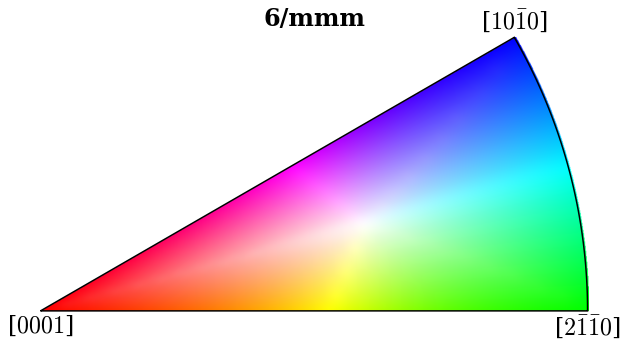

In [6]:
ckey = plot.IPFColorKeyTSL(D6)
ckey.plot()

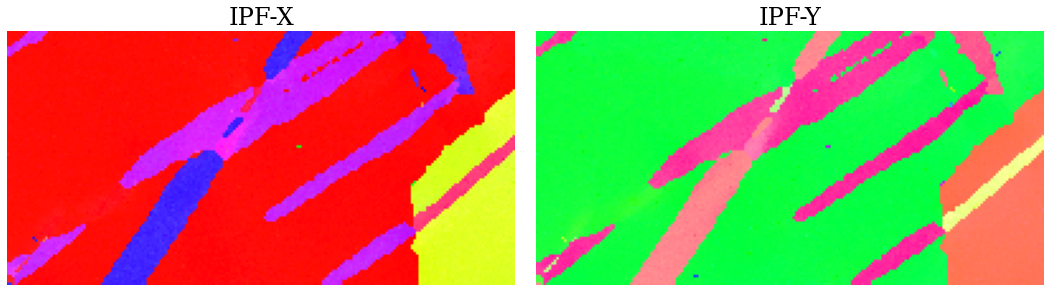

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
directions = [(1, 0, 0), (0, 1, 0)]
titles = ["X", "Y"]
for i in range(len(ax)):
    ckey.direction = Vector3d(directions[i])
    ax[i].imshow(ckey.orientation2color(~ori))  # Invert because orix assumes lab2crystal when coloring orientations
    ax[i].set_title(f"IPF-{titles[i]}")
    ax[i].axis("off")
fig.tight_layout()

Map the orientations into the fundamental zone (find
symmetrically equivalent orientations with the smallest
angle of rotation) of *D6*

In [8]:
ori = ori.map_into_symmetry_reduced_zone()

## Compute distance matrix

In [9]:
# Increase the chunk size for a faster but more memory intensive computation
D = ori.get_distance_matrix(lazy=True, chunk_size=40)

[########################################] | 100% Completed |  1min 14.1s


In [10]:
D = D.reshape(ori.size, ori.size)

## Clustering

For parameter explanations of the DBSCAN algorithm (Density-Based Spatial
Clustering for Applications with Noise), see the
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [11]:
# This call will use about 6 GB of memory, but the data precision of
# the D matrix can be reduced from float64 to float32 save memory:
D = D.astype(np.float32)

dbscan = DBSCAN(
    eps=0.05,  # Max. distance between two samples in radians
    min_samples=40,
    metric="precomputed"
).fit(D)

unique_labels, all_cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print("Labels:", unique_labels)

all_labels = dbscan.labels_.reshape(ori.shape)
n_clusters = unique_labels.size - 1
print("Number of clusters:", n_clusters)

Labels: [-1  0  1  2  3  4  5  6]
Number of clusters: 7


Calculate the mean orientation of each cluster

In [12]:
unique_cluster_labels = unique_labels[1:]  # Without the "no-cluster" label -1
cluster_sizes = all_cluster_sizes[1:]

q_mean = [ori[all_labels == l].mean() for l in unique_cluster_labels]
cluster_means = Orientation.stack(q_mean).flatten()

# Map into the fundamental zone
cluster_means.symmetry = D6
cluster_means = cluster_means.map_into_symmetry_reduced_zone()
cluster_means

Orientation (7,) 622
[[ 0.7093  0.1617 -0.6683 -0.1554]
 [ 0.8519  0.3835  0.3346 -0.1231]
 [ 0.8647  0.4319 -0.1888  0.1735]
 [ 0.8596  0.4059  0.2586 -0.1716]
 [ 0.785   0.2649  0.5591  0.0311]
 [ 0.7096  0.6541  0.2039  0.1642]
 [ 0.7942 -0.3078 -0.5239 -0.002 ]]

Inspect rotation axes in the axis-angle representation

In [13]:
cluster_means.axis

Vector3d (7,)
[[ 0.2293 -0.948  -0.2205]
 [ 0.7324  0.639  -0.2351]
 [ 0.8599 -0.3759  0.3454]
 [ 0.7944  0.5061 -0.3358]
 [ 0.4276  0.9026  0.0502]
 [ 0.9284  0.2895  0.2331]
 [-0.5065 -0.8622 -0.0033]]

Recenter data relative to the matrix cluster and recompute means

In [14]:
ori_recentered = (~cluster_means[0]) * ori

# Map into the fundamental zone
ori_recentered.symmetry = D6
ori_recentered = ori_recentered.map_into_symmetry_reduced_zone()

cluster_means_recentered = Orientation.stack(
    [ori_recentered[all_labels == l].mean() for l in unique_cluster_labels]
).flatten()
cluster_means_recentered

Orientation (7,) 1
[[ 1.      0.     -0.     -0.    ]
 [ 0.8464 -0.2653 -0.4618 -0.    ]
 [ 0.7824  0.3119  0.5391 -0.0007]
 [ 0.7932 -0.3012 -0.5292  0.0059]
 [ 0.9674 -0.1234 -0.2211  0.0051]
 [ 0.8606 -0.4344 -0.2657  0.0035]
 [ 0.9545 -0.2864 -0.0372 -0.0749]]

Inspect recentered rotation axes in the axis-angle representation

In [15]:
cluster_means_recentered_axangle = AxAngle.from_rotation(cluster_means_recentered)
cluster_means_recentered_axangle.axis

Vector3d (7,)
[[ 0.2883 -0.7832 -0.551 ]
 [-0.4981 -0.8671 -0.    ]
 [ 0.5007  0.8656 -0.0011]
 [-0.4947 -0.869   0.0097]
 [-0.4871 -0.8731  0.0203]
 [-0.853  -0.5218  0.0069]
 [-0.9599 -0.1247 -0.2511]]

## Visualisation

Specify colours and lines to identify each cluster

In [16]:
colors = [to_rgb(f"C{i}") for i in range(cluster_means_recentered_axangle.size)]
labels_rgb = label2rgb(all_labels, colors=colors, bg_label=-1)

lines = [((0, 0, 0), tuple(cm)) for cm in cluster_means_recentered_axangle.data]

Inspect rotation axes of clusters (in the axis-angle representation)
in an inverse pole figure

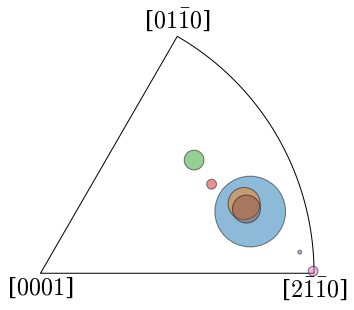

In [17]:
cluster_sizes_scaled = 5000 * cluster_sizes / cluster_sizes.max()
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="ipf", symmetry=D6))
ax.scatter(
    cluster_means.axis, c=colors, s=cluster_sizes_scaled, alpha=0.5, ec="k"
)

Plot a top view of the recentered orientation clusters within the fundamental zone
for the *D6* (*622*) point group symmetry of Ti. The mean orientation of the largest
parent grain is taken as the reference orientation.

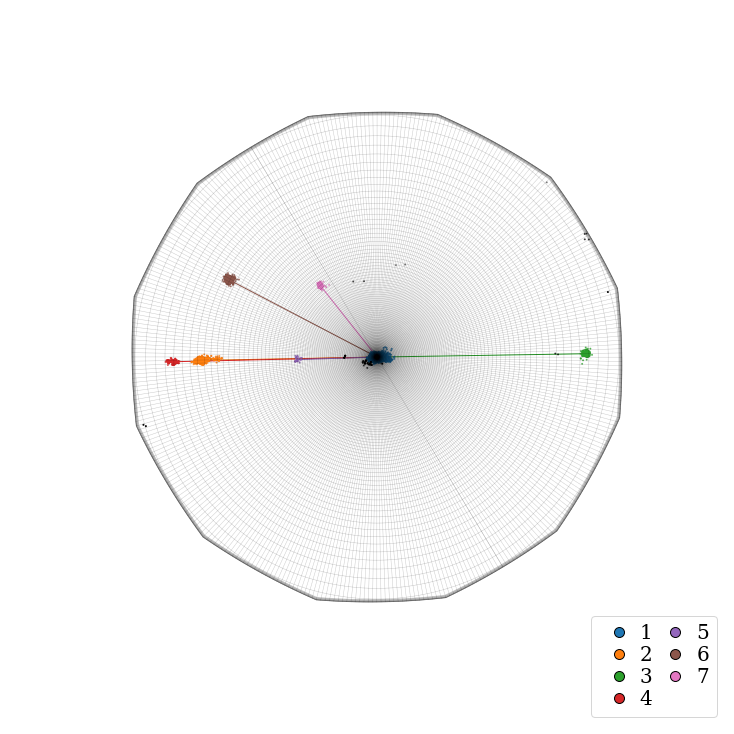

In [18]:
wireframe_kwargs = dict(color="black", linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
fig = ori_recentered.scatter(
    projection="axangle",
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=1,
    return_figure=True
)
ax = fig.axes[0]
ax.view_init(elev=90, azim=-30)
ax.add_collection3d(Line3DCollection(lines, colors=colors))

handle_kwds = dict(marker="o", color="none", markersize=10)
handles = []
for i in range(n_clusters):
    line = Line2D([0], [0], label=i + 1, markerfacecolor=colors[i], **handle_kwds)
    handles.append(line)
ax.legend(
    handles=handles,
    loc="lower right",
    ncol=2,
    numpoints=1,
    labelspacing=0.15,
    columnspacing=0.15,
    handletextpad=0.05
);

Plot side view of orientation clusters

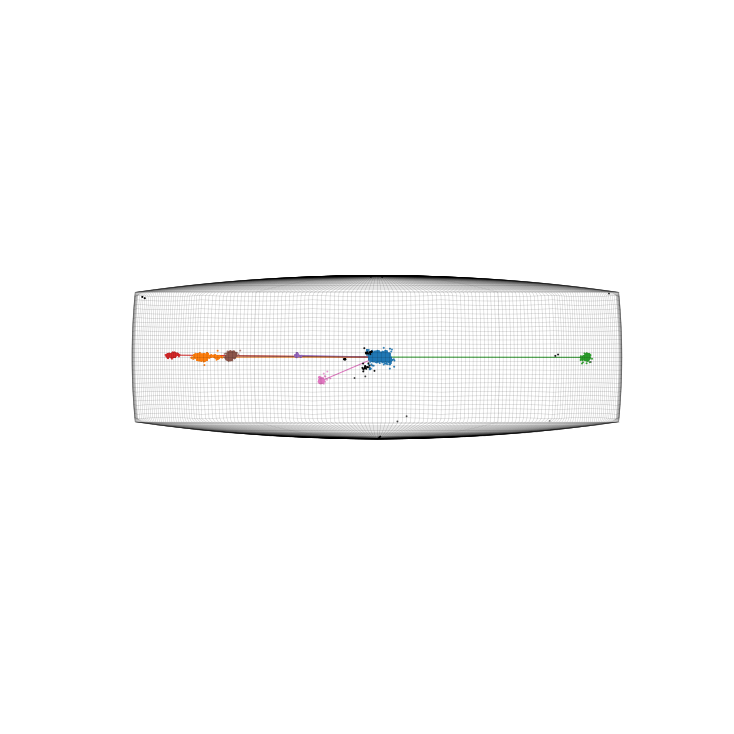

In [19]:
fig2 = ori_recentered.scatter(
    return_figure=True,
    wireframe_kwargs=wireframe_kwargs,
    c=labels_rgb.reshape(-1, 3),
    s=1,
)
ax2 = fig2.axes[0]
ax2.add_collection3d(Line3DCollection(lines, colors=colors))
ax2.view_init(elev=0, azim=-30)

Plot map indicating spatial locations associated with each cluster

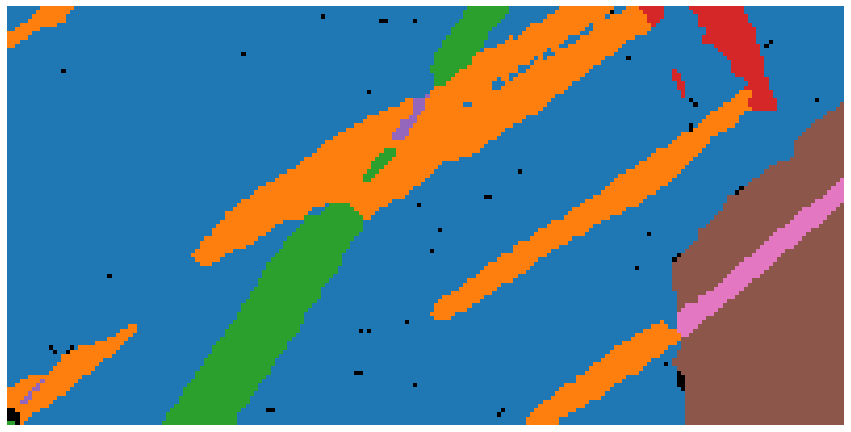

In [20]:
fig3, ax3 = plt.subplots(figsize=(15, 10))
ax3.imshow(labels_rgb)
ax3.axis("off");